In [1049]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import requests
from bs4 import BeautifulSoup
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split, cross_val_score

sns.set()
pd.set_option('display.precision', 3)

import warnings

warnings.filterwarnings('ignore')

## Lectura de los datos

In [1050]:
# Leemos del csv
df_train = pd.read_csv("../train.csv", header= 0, delimiter = ',')
df_test = pd.read_csv("../test.csv",  header= 0, delimiter = ',')

df_train['origin'] = 'train'
df_test['origin'] = 'test'

df_combined = pd.concat([df_train, df_test], ignore_index=True)


In [1051]:
# remove spaces and symbols to avoid problems with statsmodel GLM
df_combined.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_') 
                                for c in df_combined.columns] 

# We rename the variables
renaming = {
    'characteristics.lotfeatures': 'lot_features',
    'characteristics.lotsizesquarefeet': 'lot_size_sqft',
    'imagedata.c1c6.summary.bathroom': 'c_bathroom',
    'imagedata.c1c6.summary.exterior': 'c_exterior',
    'imagedata.c1c6.summary.interior': 'c_interior',
    'imagedata.c1c6.summary.kitchen': 'c_kitchen',
    'imagedata.c1c6.summary.property': 'c_property',
    'imagedata.features_reso.results': 'features_reso',
    'imagedata.q1q6.summary.bathroom': 'q_bathroom',
    'imagedata.q1q6.summary.exterior': 'q_exterior',
    'imagedata.q1q6.summary.interior': 'q_interior',
    'imagedata.q1q6.summary.kitchen': 'q_kitchen',
    'imagedata.q1q6.summary.property': 'q_property',
    'imagedata.room_type_reso.results': 'room_type_reso',
    'imagedata.style.exterior.summary.label': 'style_exterior',
    'imagedata.style.stories.summary.label': 'style_stories',
    'listing.dates.closedate': 'close_date',
    'listing.listingid': 'listing_id',
    'listing.price.closeprice': 'close_price',
    'location.address.censusblock': 'census_block',
    'location.address.censustract': 'census_tract',
    'location.address.city': 'city',
    'location.address.countyorparish': 'county_or_parish',
    'location.address.postalcode': 'postal_code',
    'location.address.postalcodeplus4': 'postal_code_plus4',
    'location.address.stateorprovince': 'state_or_province',
    'location.address.streetdirectionprefix': 'street_direction_prefix',
    'location.address.streetdirectionsuffix': 'street_direction_suffix',
    'location.address.streetname': 'street_name',
    'location.address.streetnumber': 'street_number',
    'location.address.streetsuffix': 'street_suffix',
    'location.address.unitnumber': 'unit_number',
    'location.address.unparsedaddress': 'unparsed_address',
    'location.area.subdivisionname': 'subdivision_name',
    'location.gis.latitude': 'latitude',
    'location.gis.longitude': 'longitude',
    'location.school.highschooldistrict': 'high_school_district',
    'property.propertytype': 'property_type',
    'structure.basement': 'basement',
    'structure.bathroomsfull': 'bathrooms_full',
    'structure.bathroomshalf': 'bathrooms_half',
    'structure.bedroomstotal': 'bedrooms_total',
    'structure.belowgradefinishedarea': 'below_grade_finished_area',
    'structure.belowgradeunfinishedarea': 'below_grade_unfinished_area',
    'structure.cooling': 'cooling',
    'structure.fireplacestotal': 'fireplaces_total',
    'structure.garagespaces': 'garage_spaces',
    'structure.heating': 'heating',
    'structure.livingarea': 'living_area',
    'structure.newconstructionyn': 'new_construction',
    'structure.parkingfeatures': 'parking_features',
    'structure.rooms.roomstotal': 'rooms_total',
    'structure.yearbuilt': 'year_built',
    'tax.zoning': 'zoning',
    'unittypes.unittypetype': 'unit_type'
}


df_combined.rename(columns=renaming, inplace=True)
categorical_columns = df_combined.select_dtypes(include=['object']).columns.tolist()

# The target variable should be the first column
cols = list(df_combined.columns)
cols.remove('close_price')
cols.insert(0, 'close_price')
df_combined = df_combined.reindex(columns=cols)

# peek into the data
df_combined.head()

,close_price,lot_features,lot_size_sqft,c_bathroom,c_exterior,c_interior,c_kitchen,c_property,features_reso,q_bathroom,...,garage_spaces,heating,living_area,new_construction,parking_features,rooms_total,year_built,zoning,unit_type,origin
0,3.000e+04,NaN,3200.0,NaN,NaN,NaN,NaN,NaN,"['Cooling.CeilingFans', 'Flooring.Carpet', 'Fl...",NaN,...,NaN,NaN,NaN,False,NaN,NaN,0.0,commr,NaN,train
1,3.990e+05,NaN,NaN,NaN,3.8,3.7,3.8,3.8,"['Appliances.GasRange', 'Appliances.Range', 'A...",NaN,...,NaN,['natural gas'],3175.0,False,['off alley'],6.0,NaN,NaN,NaN,train
2,2.050e+06,NaN,18750.0,NaN,NaN,NaN,NaN,NaN,"['Flooring.Carpet', 'ParkingFeatures.Garage', ...",NaN,...,NaN,NaN,NaN,False,NaN,NaN,1926.0,commr,NaN,train
3,1.620e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['CommunityFeatures.Lake', 'WaterfrontFeatures...",NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,agric,NaN,train
4,3.225e+06,"['horses allowed', 'paddock', 'pond(s)']",NaN,NaN,3.6,NaN,NaN,3.6,"['Appliances.Refrigerator', 'Appliances.Microw...",NaN,...,NaN,['other'],0.0,False,"['unassigned', 'off street']",4.0,2006.0,NaN,NaN,train


## Análisis de nuestros datos

A continuación vemos como hay una mezcla de variables categóricas y numéricas, y la variable objetivo es: **closeprice**

In [1052]:
df_combined.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129476 entries, 0 to 129475
Data columns (total 56 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   close_price                  107437 non-null  float64
 1   lot_features                 51009 non-null   object 
 2   lot_size_sqft                1964 non-null    float64
 3   c_bathroom                   110131 non-null  float64
 4   c_exterior                   105265 non-null  float64
 5   c_interior                   113401 non-null  float64
 6   c_kitchen                    111964 non-null  float64
 7   c_property                   124077 non-null  float64
 8   features_reso                126198 non-null  object 
 9   q_bathroom                   110093 non-null  float64
 10  q_exterior                   98797 non-null   float64
 11  q_interior                   113395 non-null  float64
 12  q_kitchen                    111936 non-null  float64
 13 

In [1053]:
df_combined.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
close_price,107437.0,NaN,NaN,NaN,392257.955,386136.219,1.0,209000.0,310000.0,455000.0,35550000.0
lot_features,51009,5866,['fenced yard'],10138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lot_size_sqft,1964.0,NaN,NaN,NaN,55641.602,445632.673,0.0,3714.0,8500.0,23958.0,9999999.0
c_bathroom,110131.0,NaN,NaN,NaN,3.111,0.72,1.0,2.8,3.2,3.6,6.0
c_exterior,105265.0,NaN,NaN,NaN,3.301,0.674,1.0,3.1,3.4,3.7,6.0
c_interior,113401.0,NaN,NaN,NaN,3.208,0.672,1.0,2.9,3.3,3.6,6.0
c_kitchen,111964.0,NaN,NaN,NaN,3.113,0.738,1.0,2.8,3.2,3.6,6.0
c_property,124077.0,NaN,NaN,NaN,3.177,0.677,1.0,2.9,3.2,3.6,6.0
features_reso,126198,113137,['Levels.Two'],1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q_bathroom,110093.0,NaN,NaN,NaN,3.332,0.524,1.0,3.0,3.3,3.7,5.1


A continuación podemos ver histogramas y barplots de nuestros datos:

In [1054]:
# Esta comentado porque al haber tantos ejemplos tarda demasiado

"""
fig, axes = plt.subplots(1,3,figsize=(10,4))

# We will not plot country because it has too many categories.
for i, c in enumerate(df_combined.columns[1:2]):
    ax = axes.reshape(-1)[i]
    if df_combined[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=df_combined,ax=ax)
    else:
        b = sns.histplot(x=c,data=df_combined,ax=ax, bins=20, kde=True, color="skyblue")
        ax.set_title(c, fontsize=16)
        ax.set_xlabel('Valor', fontsize=14)
        ax.set_ylabel('Frecuencia', fontsize=14)

        mean = df_combined[c].mean()
        median = df_combined[c].median()
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
        ax.legend()

plt.tight_layout()
plt.show();
"""


'\nfig, axes = plt.subplots(1,3,figsize=(10,4))\n\n# We will not plot country because it has too many categories.\nfor i, c in enumerate(df_combined.columns[1:2]):\n    ax = axes.reshape(-1)[i]\n    if df_combined[c].dtype.kind == \'O\':\n        a = sns.countplot(x=c,data=df_combined,ax=ax)\n    else:\n        b = sns.histplot(x=c,data=df_combined,ax=ax, bins=20, kde=True, color="skyblue")\n        ax.set_title(c, fontsize=16)\n        ax.set_xlabel(\'Valor\', fontsize=14)\n        ax.set_ylabel(\'Frecuencia\', fontsize=14)\n\n        mean = df_combined[c].mean()\n        median = df_combined[c].median()\n        ax.axvline(mean, color=\'red\', linestyle=\'dashed\', linewidth=1, label=\'Media\')\n        ax.legend()\n\nplt.tight_layout()\nplt.show();\n'

Ahora que sabemos cómo se ven nuestros datos, es una buena idea verificar cuántos valores perdidos tenemos en cada variable, si es que tenemos.

In [1055]:
df_combined.shape # devuelve la tupla (#filas, #columnas)
df_combined.isna().sum().sort_values(ascending=False)

street_direction_suffix        128703
lot_size_sqft                  127512
postal_code_plus4              125491
unit_type                      123605
zoning                         120621
below_grade_unfinished_area    115274
parking_features               113169
below_grade_finished_area      112141
unit_number                     99950
subdivision_name                85203
lot_features                    78467
street_direction_prefix         70964
fireplaces_total                67203
q_exterior                      30679
style_stories                   29490
style_exterior                  29471
c_exterior                      24211
garage_spaces                   22402
close_price                     22039
q_bathroom                      19383
c_bathroom                      19345
q_kitchen                       17540
c_kitchen                       17512
q_interior                      16081
c_interior                      16075
living_area                      9342
bathrooms_ha

<Axes: >

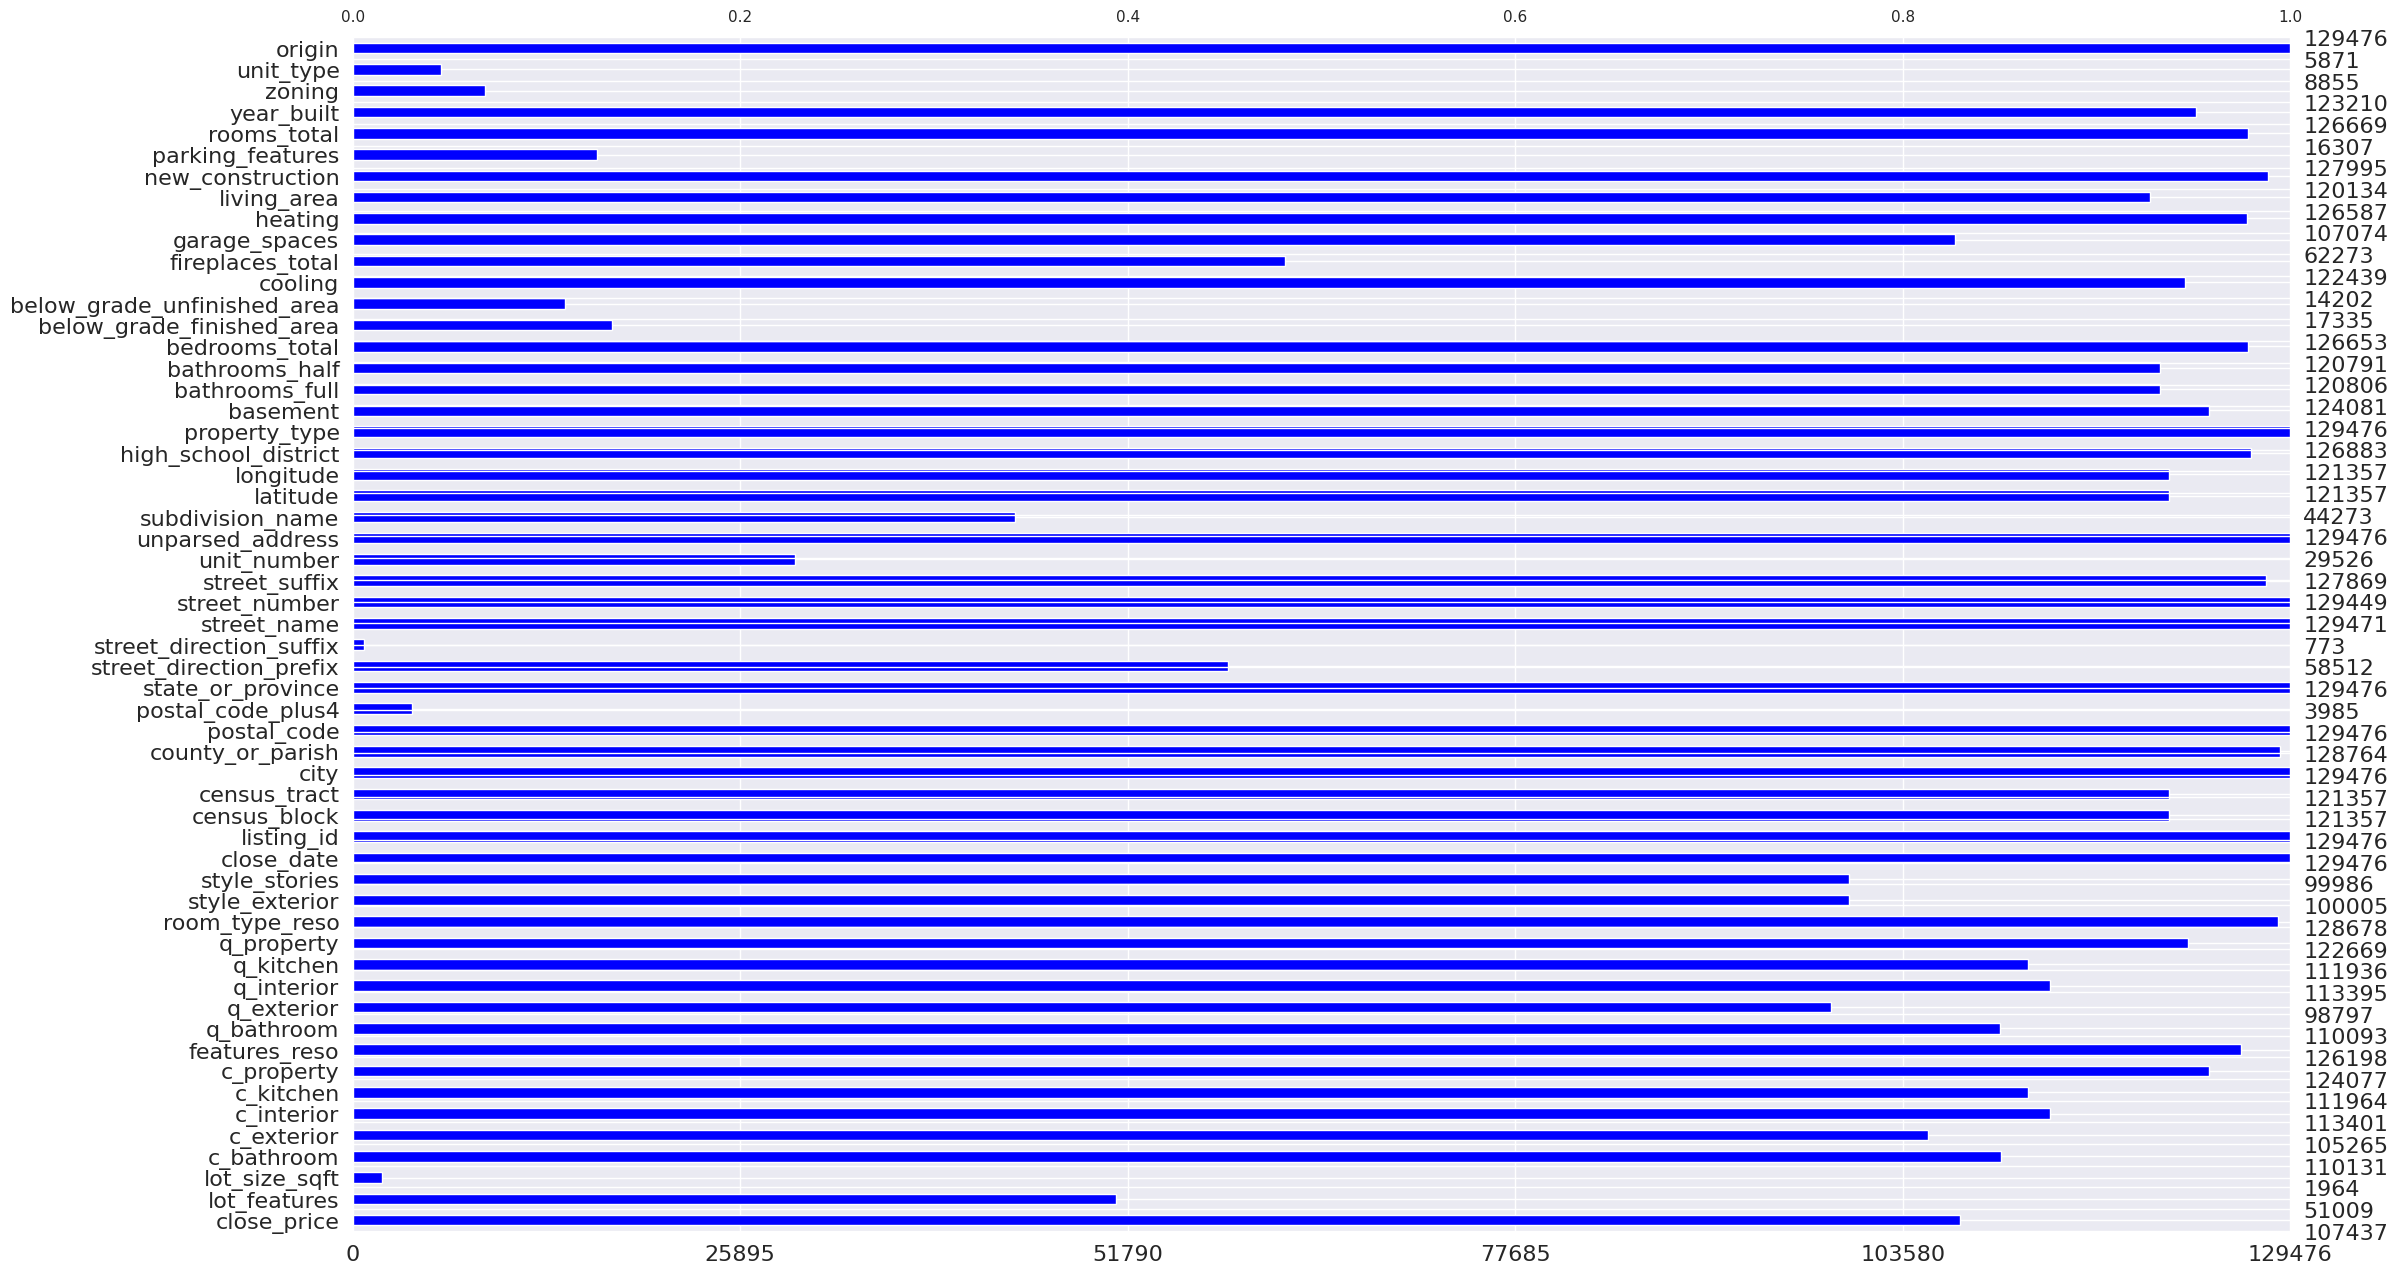

In [1056]:
msno.bar(df_combined, color="blue")

Los valores perdidos pueden presentar patrones que pueden indicar cosas interesantes en los datos, pueden ser totalmente aleatorios o estar relacionados entre las diferentes columnas. Vamos a ver como són:

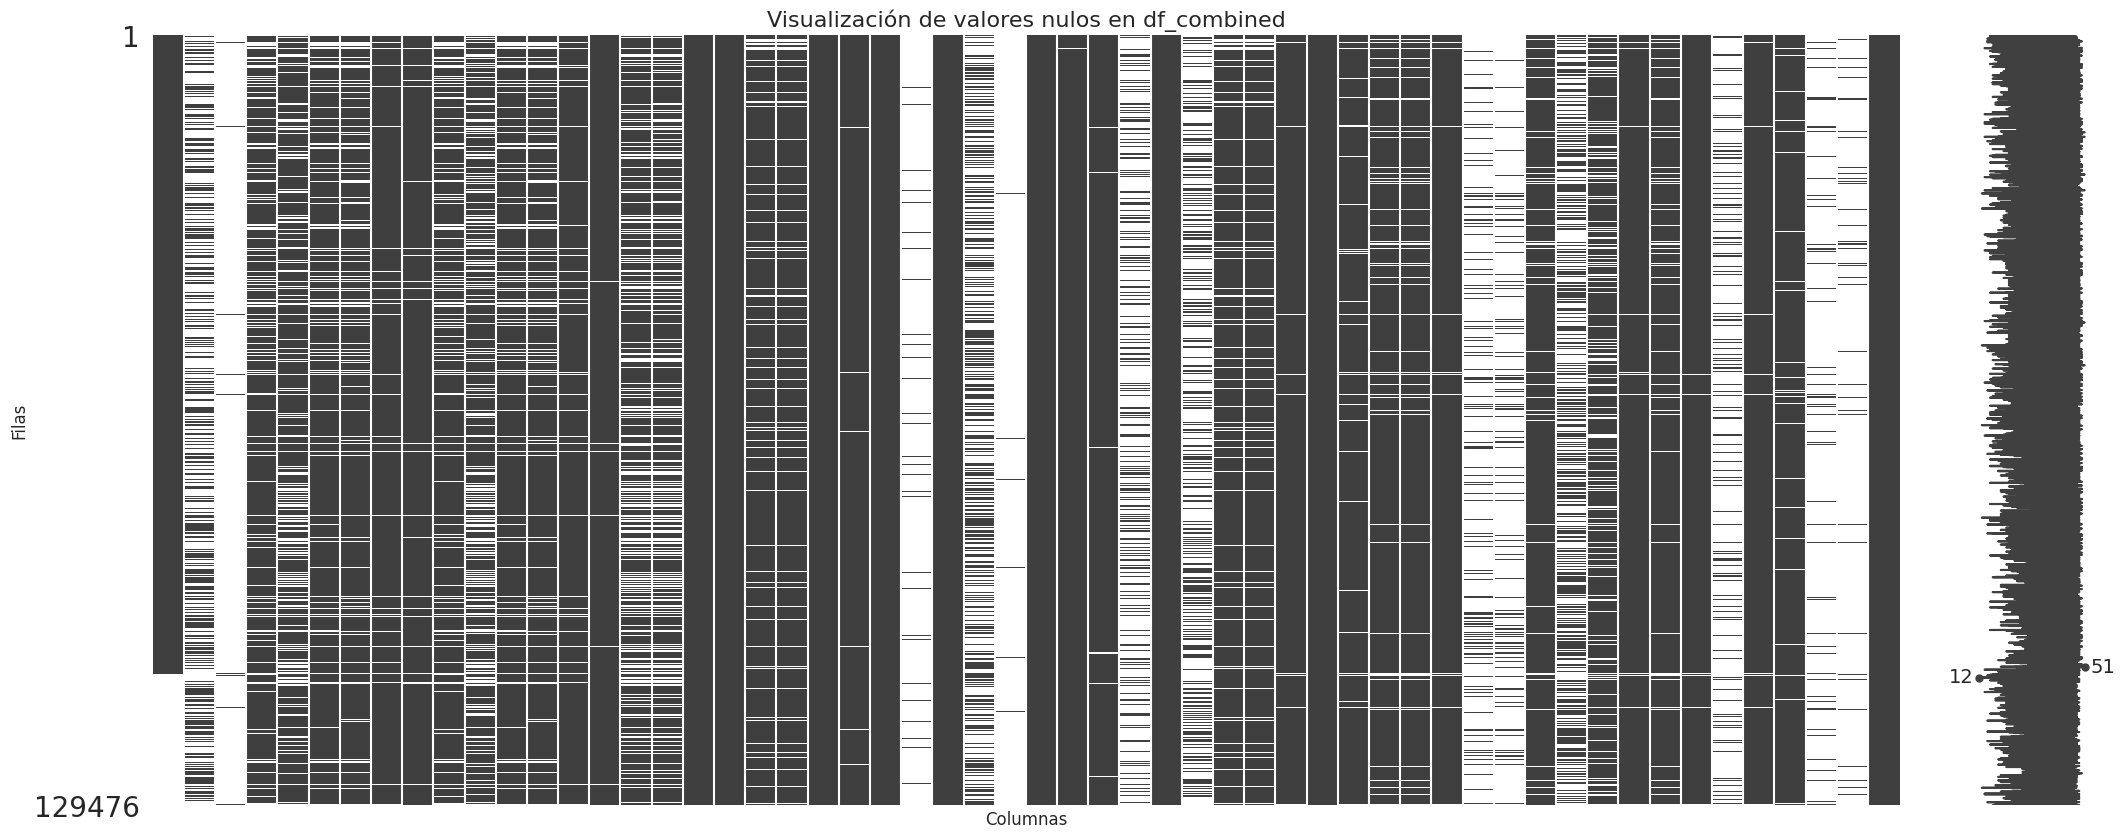

In [1057]:
msno_plot = msno.matrix(df_combined)

msno_plot.set_title("Visualización de valores nulos en df_combined", fontsize=16)
msno_plot.set_xlabel("Columnas", fontsize=12)
msno_plot.set_ylabel("Filas", fontsize=12)

plt.show()

Vemos como en general no se sigue ningún patrón evidente en la aparición de valores perdidos. Hay varias opciones posibles para tratar los valores perdidos:
- Eliminar la variable con missing values
- Eliminarlas filas con missing values
- Tratar de imputar los missing values de alguna forma concreta


Podriamos mirar también si tenemos outliers (si sobra tiempo).

## Preprocessing

Nuestro preprocesado se ha basado en 3 pasos básicos:
- Eliminación de variables irrelevantes
- Eliminación de variables con demasiados missing values
- Codificación de variables categóricas
- Tratamiento de missing values

Todas las decisiones que hemos tomado tienen su propia justificación.

### Eliminación de variables irrelevantes

Hemos considerado como variables irrelevantes las siguientes:
- **listing_id**: porque un identificador único por fila no aporta nada en la toma de decisiones.
- **unparsed_address, street_number y street_suffix**: porque son identificadores muy concretos que llevan a posibles sobreajustes, redundancia y no aportan información que consideremos razonable.
- **state_or_province**: porque siempre es Ilinois
- **street_name', 'census_block', 'census_tract' y 'high_school_district'**: porque son variables categoricas que tienen muchas categorias posibles y, a parte de estar estrechamente relacionadas con otras, no aportan lo suficiente como para tratar de codificarlas sin aumentar mucho la dimensionalidad de nuestro espacio.
- **basement**: porque es una variable categorica relacionada con el sótano y consideramos que su codificación es innecesaria (habrá que revisar si el modelo mejora con ella)
- **city**: es redundante

 

In [1058]:
columns_to_remove = ['listing_id', 'unparsed_address', 'street_number', 'street_suffix', 'state_or_province', 'street_name',
                                                 'census_block', 'census_tract', 'high_school_district', 'basement', 'city']

df_without_irrelevant_vars = df_combined.drop(columns=columns_to_remove, inplace=False)


### Eliminación de variables con demasiados missing values

En este apartado hemos decidido eliminar todas aquellas variables que superen el treshold del 50% de valores perdidos, ya que no tendria sentido imputar valores dada una pérdida de información tan elevada.

In [1059]:
columns_with_many_missing = []

threshold = len(df_without_irrelevant_vars) * 0.5

for column in df_without_irrelevant_vars.columns:
    if df_without_irrelevant_vars[column].isna().sum() > threshold:
        columns_with_many_missing.append(column)

df_clean = df_without_irrelevant_vars.drop(columns=columns_with_many_missing, inplace=False)
categorical_columns = df_clean.select_dtypes(include=['object']).columns.tolist()


elimino filas nan de county_or_panish

In [1060]:
df_clean = df_clean.dropna(subset=['county_or_parish'])

### Codificación de variables categóricas

Antes de nada vamos a ver qué variables categoricas tenemos, teniendo en cuenta que debemos ignorar las eliminadas en los apartados anteriores. Vamos a mostrar también las categorias posibles, algo muy importante de cara a encarar la codificación.

In [1061]:
print(f"Tenemos {len(categorical_columns)-1} variables categoricas:\n");

for column in categorical_columns:
    if column != 'origin': print(f"Column: {column}: {df_clean[column].nunique()}")

Tenemos 11 variables categoricas:

Column: features_reso: 112557
Column: room_type_reso: 109106
Column: style_exterior: 41
Column: style_stories: 5
Column: close_date: 412
Column: county_or_parish: 83
Column: postal_code: 1544
Column: property_type: 7
Column: cooling: 196
Column: heating: 769
Column: new_construction: 2


Vemos como **features_reso** y **room_type_reso** tienen muchos valores posibles. Se tratan de características específicas de la vivienda, que aportan un valor añadido. Después de habernos informado sobre estudios previos en este tipo de predicciones, hemos llegado a la conclusión de que lo ideal es, dado el array de features pertinente, codificar la variable como el size de dicho array. Es decir, como mas "extras" hayan, mas grande será el número. Algo similar sucede con **cooling**

In [1062]:
df_clean['features_reso'] = df_clean['features_reso'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['room_type_reso'] = df_clean['room_type_reso'].apply(lambda x: len(x) if isinstance(x, list) else 0)

df_clean['cooling'] = df_clean['cooling'].apply(lambda x: len(x) - 1 if isinstance(x, list) and 'none' in x else len(x) if isinstance(x, list) else 0)
df_clean['heating'] = df_clean['heating'].apply(lambda x: len(x) - 1 if isinstance(x, list) and 'none' in x else len(x) if isinstance(x, list) else 0)

categorical_columns = df_clean.select_dtypes(include=['object']).columns.tolist()

In [1063]:
print(f"Tenemos {len(categorical_columns)-1} variables categoricas:\n");

for column in categorical_columns:
     if column != 'origin': print(f"Column: {column}: {df_clean[column].nunique()}")

Tenemos 7 variables categoricas:

Column: style_exterior: 41
Column: style_stories: 5
Column: close_date: 412
Column: county_or_parish: 83
Column: postal_code: 1544


Column: property_type: 7
Column: new_construction: 2


En este punto hemos decidido lo siguiente:
- **style_exterior**: vamos a hacer un procesado que agrupo los distintos tipos de habitaje, para posteriormente hacer un One-Hot encoding mas viable
- **style_stories**: haremos un One-Hot encoding
- **county_or_parish:**:  mapeo a una numérica relacionada con la renta media de la zona
- **postal_code**: mapeo a una numérica relacionada con la renta media de la zona
- **property_type:**: One-Hot encoding
- **new_construction**: es una categórica booleana, es trivial pasarla a numérica
- **close_date**: agruparemos por seasons, aportan información muy importante

#### style_stories y property_type

Vamos a hacer un One-Hot encoding directamente

In [1064]:
# Generamos c-1 variables, las añadimos al dataframe y eliminamos la variable
dummies = pd.get_dummies(df_clean['style_stories'], drop_first=False, prefix='style_stories', prefix_sep='_').astype(int)
df_clean = pd.concat([df_clean,dummies], axis=1)
df_clean.drop(columns=['style_stories'], inplace=True)

dummies = pd.get_dummies(df_clean['property_type'], drop_first=False, prefix='property_type', prefix_sep='_').astype(int)
df_clean = pd.concat([df_clean,dummies], axis=1)
df_clean.drop(columns=['property_type'], inplace=True)

#### style_exterior
Procedemos ahora a tratar la variable style_exterior ya que consideramos que es una variable que nos puede aportar información muy relevante.

Decidimos que para clasificar y agrupar los distintos valores mostramos la mediana de cada valor y crearemos intervalos argupando distintos estilos en como de caro o barato suele ser ese estilo arquitectónico para ver que estilos de casas que influyen de la misma forma al precio de una casa.

In [1065]:
df_clean['style_exterior'].value_counts().describe().apply(lambda x: f"{int(x):,}")
max_median = 0
min_median = float('inf')
for value in df_clean['style_exterior'].dropna().unique():
    median_value = df_clean[df_clean['style_exterior'] == value]['close_price'].median()
    if median_value > max_median:
        max_median = median_value
    if median_value < min_median:
        min_median = median_value
        
print("Max median: ", max_median)
print("Min median: ", min_median)

Max median:  815000.0
Min median:  80750.0


Vemos que las medianas de los valores unicos que puede tomar style_exterior van de  80.000 a 815.000 entonces crearemos 5 intervalos

In [1066]:
df_clean['style_exterior'].value_counts().describe().apply(lambda x: f"{int(x):,}")
for value in df_clean['style_exterior'].dropna().unique():
    median_value = df_clean[df_clean['style_exterior'] == value]['close_price'].median()
    if median_value < 150000:
        df_clean.loc[df_clean['style_exterior'] == value, 'style_exterior'] = 'economical'
    elif median_value < 300000:
        df_clean.loc[df_clean['style_exterior'] == value, 'style_exterior'] = 'accessible'
    elif median_value < 450000:
        df_clean.loc[df_clean['style_exterior'] == value, 'style_exterior'] = 'average'
    elif median_value < 600000:
        df_clean.loc[df_clean['style_exterior'] == value, 'style_exterior'] = 'high'
    else:
        df_clean.loc[df_clean['style_exterior'] == value, 'style_exterior'] = 'expensive'

In [1067]:
df_clean['style_exterior'].value_counts()

style_exterior
average       55688
accessible    36558
high           3925
expensive      2693
economical      541
Name: count, dtype: int64

In [1068]:
dummies = pd.get_dummies(df_clean['style_exterior'], drop_first=False, prefix='style_exterior', prefix_sep='_').astype(int)
df_clean = pd.concat([df_clean,dummies], axis=1)
df_clean.drop(columns=['style_exterior'], inplace=True)

#### postal_code

A continuación vamos a canviar los valores de las variables postal code i county or parish por la renta per capità. Para ello hemos extraído los datos sobre renta per capità de wikipedia. Además para poder relacions los códigos postales con los condados y sus respectivos nombres, hemos utilizado la información de la página zipdatamaps.com

In [1069]:
url = "https://en.wikipedia.org/wiki/List_of_Illinois_locations_by_per_capita_income"

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

name_to_income_capita = {}
for link in soup.find_all('li'):
    if '$' in link.text:
       coun = link.text.split('–')[0][:-1]
       if ',' in coun:
           coun = coun.split(',')[0]
       inc = link.text.split('$')[1]
       name_to_income_capita[coun.lower()] = inc
# In wikipedia seems the poorest country and the previous one is zero, therefore, it should be zero too.
name_to_income_capita['Ohlman'] = 0

In [1070]:
url2 = "https://www.zipdatamaps.com/en/us/zip-list/state/zip-codes-in-illinois"
response2 = requests.get(url2)
soup2 = BeautifulSoup(response2.content, 'html.parser')

cp_to_county = {}
cp_to_name = {}
for row in soup2.find_all('tr'):
    soup3 = BeautifulSoup(str(row), 'html.parser')
    columns = soup3.find_all('a')
    if len(columns) > 2:
        county_name = columns[2].text.split(" County")[0]
        cp_to_county[columns[0].text] = county_name.lower()
        cp_to_name[columns[0].text] = columns[1].text.lower()

In [1071]:
county_to_income_capita = {}
county_capita_list = soup.find_all('tr')[8:112]
for row in county_capita_list:
    soup4 = BeautifulSoup(str(row), 'html.parser')
    soup5 = BeautifulSoup(str(row), 'html.parser')
    columns = soup4.find_all('td')
    count = soup4.find_all('a')
    county_to_income_capita[count[0].text.lower()] = columns[2].text[1:-1]

county_to_income_capita['de witt'] = county_to_income_capita['dewitt']
county_to_income_capita['saint clair'] = county_to_income_capita['st. clair']

A continuación hacemos las transformaciones pertinenetes para canviar los valores de las variables postal code i county or parish por la renta per capità.

In [1072]:
df_clean['postal_code'] = df_clean['postal_code'].astype(str)
df_clean['county_or_parish'] = df_clean['postal_code'].map(cp_to_county)
df_clean['county_or_parish'] = df_clean['county_or_parish'].map(county_to_income_capita)
df_clean['postal_code'] = df_clean['postal_code'].map(cp_to_name)
df_clean['postal_code'] = df_clean['postal_code'].map(name_to_income_capita)

In [1073]:
df_clean['county_or_parish'].isna().sum()

np.int64(686)

En las siguientes celdas, formateamos con sus respectivos tipos.

In [1074]:
df_clean['postal_code'] = df_clean['postal_code'].str.replace(',', '.')
df_clean['county_or_parish'] = df_clean['county_or_parish'].str.replace(',', '.')

In [1075]:
df_clean['postal_code'] = df_clean['postal_code'].astype(float)
df_clean['county_or_parish'] = df_clean['county_or_parish'].astype(float)

#### county_or_parish

#### new_construction
En esta variable vamos a pasar de bool a números (1 y 0). Los Nan's los dejamos intactos, se trataran en un apartado posterior

In [1076]:
df_clean['new_construction'] = df_clean['new_construction'].map(
    lambda x: 1 if x is True else (0 if x is False else x)
)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128764 entries, 0 to 129475
Data columns (total 46 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   close_price                         106824 non-null  float64
 1   c_bathroom                          109582 non-null  float64
 2   c_exterior                          104639 non-null  float64
 3   c_interior                          112816 non-null  float64
 4   c_kitchen                           111395 non-null  float64
 5   c_property                          123429 non-null  float64
 6   features_reso                       128764 non-null  int64  
 7   q_bathroom                          109544 non-null  float64
 8   q_exterior                          98186 non-null   float64
 9   q_interior                          112811 non-null  float64
 10  q_kitchen                           111367 non-null  float64
 11  q_property                     

#### close_date


In [1077]:
def classify_season(date):
    date = date.split('T')[0]  # Eliminar la parte de tiempo
    month = pd.to_datetime(date).month
    if month in [3, 4, 5]:
        return 'primavera'
    elif month in [6, 7, 8]:
        return 'verano'
    elif month in [9, 10, 11]:
        return 'otoño'
    else:
        return 'invierno'

df_clean['close_date'] = df_clean['close_date'].apply(classify_season)

In [1078]:
df_clean.rename(columns={'close_date': 'season'}, inplace=True)
df_clean['season'].value_counts()

season
verano       50503
primavera    30295
otoño        27352
invierno     20614
Name: count, dtype: int64

In [1079]:
dummies = pd.get_dummies(df_clean['season'], drop_first=False, prefix='season', prefix_sep='_').astype(int)
df_clean = pd.concat([df_clean,dummies], axis=1)
df_clean.drop(columns=['season'], inplace=True)

In [1080]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128764 entries, 0 to 129475
Data columns (total 49 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   close_price                         106824 non-null  float64
 1   c_bathroom                          109582 non-null  float64
 2   c_exterior                          104639 non-null  float64
 3   c_interior                          112816 non-null  float64
 4   c_kitchen                           111395 non-null  float64
 5   c_property                          123429 non-null  float64
 6   features_reso                       128764 non-null  int64  
 7   q_bathroom                          109544 non-null  float64
 8   q_exterior                          98186 non-null   float64
 9   q_interior                          112811 non-null  float64
 10  q_kitchen                           111367 non-null  float64
 11  q_property                     

### Tratamiento de missing values

En este punto tenemos solo variables numéricas. Vamos a ver de nuevo la lista de valores faltantes. Por cada uno de ellos deberemos ver:
- Es una variable que tiene sentido y es posible imputar -> imputar
- En caso contrario, eliminamos la variable

In [1081]:
df_clean.shape # devuelve la tupla (#filas, #columnas)
df_clean.isna().sum().sort_values(ascending=False)

q_exterior                            30578
c_exterior                            24125
garage_spaces                         22359
close_price                           21940
q_bathroom                            19220
c_bathroom                            19182
q_kitchen                             17397
c_kitchen                             17369
q_interior                            15953
c_interior                            15948
living_area                            9300
bathrooms_half                         8637
bathrooms_full                         8622
latitude                               8049
longitude                              8049
q_property                             6739
year_built                             6257
c_property                             5335
bedrooms_total                         2776
rooms_total                            2773
postal_code                            1873
new_construction                       1457
county_or_parish                

Antes de nada, hemos visto en este punto que tenemos una variable que corresponde al año de construcción del habitaje. Hemos decidido transformar esta variable a "edad". Es algo que nuestro modelo va a poder manejar mejor, y tiene mas sentido

In [1082]:
df_clean["age"] = df_clean["year_built"].apply(lambda x: 2024 - x if pd.notnull(x) else x)
df_clean.drop(columns=["year_built"], inplace=True)

A continuación resumimos la decisió tomada con cada variable con missing values:
- **q_exterior**: podemos tratar de imputarla
- **c_exterior**: podemos tratar de imputarla
- **garage_spaces**: podemos tratar de imputarla
- **close_price**: no hay que hacer nada, en la partición de test no tenemos los valores, porque el accuracy en tets lo evalua restb.ai
- **q_bathroom**: podemos tratar de imputarla
- **c_bathroom**: podemos tratar de imputarla
- **q_kitchen**: podemos tratar de imputarla
- **c_kitchen**: podemos tratar de imputarla
- **q_interior** : podemos tratar de imputarla
- **c_interior** : podemos tratar de imputarla
- **living_area**: podemos tratar de imputarla
- **bathrooms_full**: podemos tratar de imputarla
- **bathrooms_half**: podemos tratar de imputarla
- **latitude**: es una variable geográfica redundante, así que la eliminamos
- **longitude**: es una variable geográfica redundante, así que la eliminamos
- **q_property**: podemos tratar de imputarla
- **age**: podemos tratar de imputarla
- **c_property**: podemos tratar de imputarla
- **bedrooms_total**: podemos tratar de imputarla
- **rooms_total**: podemos tratar de imputarla
- **new_construction**: podemos tratar de imputarla

In [1083]:
df_clean["age"].value_counts()

age
1.0      3723
19.0     2262
18.0     2241
20.0     2222
21.0     1992
         ... 
195.0       1
192.0       1
500.0       1
924.0       1
998.0       1
Name: count, Length: 204, dtype: int64

In [1084]:
# Eliminamos latitud y longitud:
df_clean.drop(columns=["latitude", "longitude"], inplace=True)

In [1085]:
df_clean.shape # devuelve la tupla (#filas, #columnas)
df_clean.isna().sum().sort_values(ascending=False)

q_exterior                            30578
c_exterior                            24125
garage_spaces                         22359
close_price                           21940
q_bathroom                            19220
c_bathroom                            19182
q_kitchen                             17397
c_kitchen                             17369
q_interior                            15953
c_interior                            15948
living_area                            9300
bathrooms_half                         8637
bathrooms_full                         8622
q_property                             6739
age                                    6257
c_property                             5335
bedrooms_total                         2776
rooms_total                            2773
postal_code                            1873
new_construction                       1457
county_or_parish                        686
room_type_reso                            0
features_reso                   

Vamos a empezar a tratar de imputar missing values, empezemos por new_construction. 

**Importante:** No debemos utilizar la variable respuesta para la imputación, estaríamos sesgando el resultado, fijaos que cuando hagamos la imputación en datos nuevos no conoceremos esa variable.

### IMPUTAR

In [1086]:
imputer = KNNImputer(n_neighbors=3)

imputed_data = imputer.fit_transform(df_clean.drop(columns=['origin', 'close_price']))

df_clean_imputed = pd.DataFrame(imputed_data, columns=df_clean.drop(columns=['origin', 'close_price']).columns)

In [1090]:
df_clean_imputed.shape
df_clean_imputed.isna().sum().sort_values(ascending=False)

c_bathroom                            0
c_exterior                            0
c_interior                            0
c_kitchen                             0
c_property                            0
features_reso                         0
q_bathroom                            0
q_exterior                            0
q_interior                            0
q_kitchen                             0
q_property                            0
room_type_reso                        0
county_or_parish                      0
postal_code                           0
bathrooms_full                        0
bathrooms_half                        0
bedrooms_total                        0
cooling                               0
garage_spaces                         0
heating                               0
living_area                           0
new_construction                      0
rooms_total                           0
style_stories_1.5_stories             0
style_stories_1_story                 0


In [1091]:
df_clean_imputed['origin'] = df_clean['origin'].values
df_clean_imputed['close_price'] = df_clean['close_price'].values

processed_train = df_clean_imputed[df_clean_imputed['origin'] == 'train'].drop(columns=['origin'])
processed_test = df_clean_imputed[df_clean_imputed['origin'] == 'test'].drop(columns=['origin'])

processed_train.to_csv('processed_train.csv', index=False)
processed_test.to_csv('processed_test.csv', index=False)

In [1088]:
df_clean_imputed.to_csv('clean_imputed_data.csv', index=False)